In [1]:
# import packages and libraries

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, MaxNLocator
import os
import sys
import warnings
from threadpoolctl import threadpool_limits
import pandas as pd
import numpy as np
from numba import njit

import _sgd_ocsvm
from _sgd_ocsvm import Sonar, detect_changepoint_sgd
from joblib import Parallel, delayed
from _rbf import PairRBFSampler, required_rff_features

import _processing
from _processing import *
import _helper_functions
from _helper_functions import run_full, run_full_cpd, OnlineStandardizer, TeeLogger

import importlib

# netml tools
from netml.utils.tool import load_data

def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

%load_ext autoreload

In [2]:
# process SKAB dataset

data_name = "skab_all"  
warnings.filterwarnings("ignore", category=UserWarning)

def load_skab_combined():
    path_to_data = "data/SKAB/"
    
    # Load anomaly-free data first
    anomaly_free_path = os.path.join(path_to_data, "anomaly-free", "anomaly-free.csv")
    anomaly_free_df = pd.read_csv(anomaly_free_path, sep=";", index_col="datetime", parse_dates=True)
    
    # Get all anomaly files
    all_files = []
    for root, dirs, files in os.walk(path_to_data):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    
    anomaly_files = [f for f in all_files if "anomaly-free" not in f]
    
    # Filter for valve1 and valve2
    valve1_files = [f for f in anomaly_files if "valve1" in f]
    valve2_files = [f for f in anomaly_files if "valve2" in f]
    
    # Load valve dataframes
    valve1_dfs = [pd.read_csv(f, sep=";", index_col="datetime", parse_dates=True) for f in valve1_files]
    valve2_dfs = [pd.read_csv(f, sep=";", index_col="datetime", parse_dates=True) for f in valve2_files]
    
    # Concatenate valve dfs
    valve1_df = pd.concat(valve1_dfs).sort_index() if valve1_dfs else pd.DataFrame()
    valve2_df = pd.concat(valve2_dfs).sort_index() if valve2_dfs else pd.DataFrame()
    
    # Concatenate in order: anomaly-free, valve1, valve2
    combined_df = pd.concat([valve1_df, valve2_df])
    
    return combined_df

# Load combined data
combined_df = load_skab_combined()

# Reset index to remove datetime
combined_df_reset = combined_df.reset_index(drop=True)

# Extract changepoint indices before dropping the column
if 'changepoint' in combined_df_reset.columns:
    changepoint_indices = combined_df_reset[combined_df_reset['changepoint'] == 1].index.tolist()
    changepoint_column = combined_df_reset['changepoint'].copy()
    
    print(f"Number of changepoints: {len(changepoint_indices)}")
    print(f"Changepoint locations (row indices): {changepoint_indices}")
    
    if len(changepoint_indices) > 0:
        print("\nContext around first few changepoints:")
        for idx in changepoint_indices[:3]:
            start = max(0, idx - 2)
            end = min(len(combined_df_reset), idx + 3)
            print(f"\nAround index {idx}:")
            print(combined_df_reset.iloc[start:end][['changepoint', 'anomaly']])
    
    # Drop changepoint column
    df_clean = combined_df_reset.drop(columns=['changepoint'])
else:
    changepoint_indices = []
    print("No 'changepoint' column found")
    df_clean = combined_df_reset.copy()

print(f"\nCombined dataframe shape: {df_clean.shape}")
print(df_clean.head())

# Prepare X and Y
df = df_clean.fillna(0)
df = df.replace([np.inf, -np.inf], 0)
df = df.astype(int)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

# Convert changepoint indices to normal-only indexing
normal_mask = (Y == 0)
changepoint_indices_normal = []

for cp_idx in changepoint_indices:
    if cp_idx < len(Y):
        normal_step = int(np.sum(normal_mask[:cp_idx+1])) - 1
        
        if normal_step >= 0 and normal_step < np.sum(normal_mask):
            changepoint_indices_normal.append(normal_step)

changepoint_indices_normal = sorted(list(set(changepoint_indices_normal)))

print(f"\nChangepoint locations in normal-only indexing: {changepoint_indices_normal}")
print(f"Number of changepoints: {len(changepoint_indices_normal)}")
print(f"Total normal points: {np.sum(Y == 0)}")
print(f"Total outlier points: {np.sum(Y != 0)}")

Number of changepoints: 79
Changepoint locations (row indices): [573, 630, 917, 974, 1719, 1776, 2063, 2121, 2858, 3138, 3195, 3940, 3998, 4285, 4344, 5088, 5146, 5380, 5437, 6187, 6245, 6533, 6590, 7340, 7398, 7686, 7745, 8496, 8553, 8842, 8901, 9584, 9641, 9927, 9984, 10730, 10787, 11073, 11132, 11877, 11934, 12221, 12278, 13022, 13080, 13364, 13421, 14161, 14218, 14503, 14560, 15301, 15358, 15643, 15700, 16440, 16497, 16782, 16839, 17584, 17642, 17930, 17988, 18722, 18778, 19060, 19116, 19845, 19901, 20123, 20178, 20913, 20969, 21252, 21308, 22041, 22098, 22380, 22436]

Context around first few changepoints:

Around index 573:
     changepoint  anomaly
571          0.0      0.0
572          0.0      0.0
573          1.0      1.0
574          0.0      1.0
575          0.0      1.0

Around index 630:
     changepoint  anomaly
628          0.0      1.0
629          0.0      1.0
630          1.0      1.0
631          0.0      1.0
632          0.0      1.0

Around index 917:
     changep

In [14]:
# process Aposemat IoT-23 datasets
data_name = "33_1"
X, Y = load_data(f"data/{data_name}.dat")

In [15]:
# online variance/norm standardizer

# Apply to TxD matrix X
T, D = X.shape
standardizer = OnlineStandardizer(D=D)
X_standardized = np.zeros_like(X)

for t in range(T):
    X_standardized[t] = standardizer.update_and_transform(X[t])

print("Result shape:", X_standardized.shape)
print("Final means:", standardizer.mean)
print("Final stds:", np.sqrt(standardizer.M2 / standardizer.n))
X = X_standardized

Result shape: (57277, 1)
Final means: [247.70751032]
Final stds: [163.79915113]


In [16]:
# get counts of normal and outlier data from Y
summarize_array(X, name='X')
unique, counts = np.unique(Y, return_counts=True)
label_counts = dict(zip(unique, counts))
normal_count = counts[0]
outlier_counts = sum(counts[1:])
print("Label counts:", label_counts)

print(f"\n normal {normal_count} and outlier {outlier_counts}")

X_copy = np.copy(X)
Y_copy = np.copy(Y)

--- X ---
Type: <class 'numpy.ndarray'>
Shape: (57277, 1)
Dtype: float64
Min: -1.5377674043108174  Max: 3.206680778604273
Mean: -0.002  Std: 0.998
Contains NaNs: False

Label counts: {np.int64(0): np.int64(1795), np.int64(1): np.int64(55482)}

 normal 1795 and outlier 55482


In [17]:
# set up hyperparameters
N = 20 # number of trials
gamma = 0.5
random_state=42
lambda_params = {
    "skab_all": 0.005,
    "33_1": 0.1,
}
lambda_param = lambda_params.get(data_name)


# Example usage:
D = X.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param)
print(f"Required number of RFF features: {n_components}")
transform = PairRBFSampler(gamma=gamma, random_state=random_state, n_components=n_components)
transform.fit(X)

Required number of RFF features: 18


PairRBFSampler(gamma=0.5, n_components=18, random_state=42)

In [18]:
# run SONAR and OCSVM for unshuffled entire datasets

importlib.reload(_sgd_ocsvm)
importlib.reload(_helper_functions)
from _sgd_ocsvm import Sonar
from _helper_functions import run_full

(avg_cum_errors, avg_cum_errors_noreg, 
 avg_radii, avg_radii_noreg, 
 avg_out_cum_errors, avg_out_cum_errors_noreg,
 f1, f1_n, f2, f2_n
) = run_full(X, Y, normal_count, outlier_counts, lambda_param=lambda_param, n_components=n_components, N=N, gamma=gamma)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [12]:
# run SONARC and ensemble method for unshuffled entire datasets
importlib.reload(_helper_functions)
importlib.reload(_sgd_ocsvm)

from _sgd_ocsvm import numba_sgd
from _helper_functions import run_full, run_full_cpd

(avg_cum_e_d, 
 avg_radii_d,
 avg_out_d,
 detected_changes,
 f1_d, f2_d
) = run_full_cpd(X, Y, 
                 normal_count, 
                 outlier_counts, 
                 lambda_param=lambda_param, 
                 n_components=n_components, 
                 N=N, 
                 gamma=gamma)

Detected 2 changes
Detected changepoints at normal steps: [285, 570]
0 Detected 1 changes
Detected changepoints at normal steps: [285]
1 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
2 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
3 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
4 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
5 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
6 Detected 1 changes
Detected changepoints at normal steps: [342]
7 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
8 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
9 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
10 Detected 1 changes
Detected changepoints at normal steps: [285]
11 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
12 Detected 2 changes
Detected changepoints at normal steps: [285, 570]
13 Detected 1 change

<Figure size 640x480 with 0 Axes>

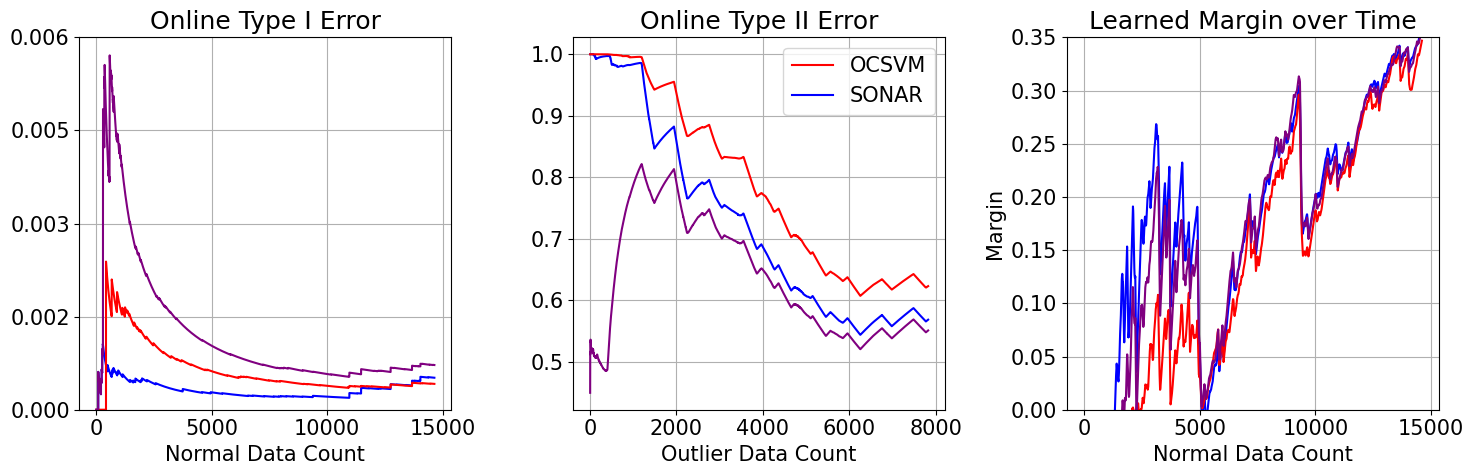

skab_all


online type 1 error
OCSVM 0.0004164959715963403
SONAR 0.0005154991123856343
SONARC 0.0007203331967772772
Normal data count 14646


online type 2 error
OCSVM 0.6233005366726296
SONAR 0.5687771530794786
SONARC 0.5512394582162023
Outlier data count 7826


last iterate type 1 error
OCSVM 0.4558241157995358
SONAR 0.3796702171241294
SONARC 0.4145193226819609
Normal data count 14646


last iterate type 2 error
OCSVM 0.24970610784564276
SONAR 0.2659276769741886
SONARC 0.2562036800408893
Outlier data count 7826

Mean detected changes of SONARC: 1.6


OCSVM Margin Statistics
Mean: -43561344475.64321
Std dev: 563423119467.7466
Min: -10539991182967.45
Max: 1.0
Median: 0.14499525728729035
25th percentile: 0.03597405745718807
75th percentile: 0.23586068134097402
last: 0.34937598567468486


SONAR Margin Statistics
Mean: 0.16845179833352641
Std dev: 0.1342179752415342
Min: -0.37753971633132144
Max: 0.3561244547499261
Median: 0.19253168437136237
last: 0.3561244547499261


SONARC Margin Stati

In [13]:
# visualize results for all algorithms (SKAB)
importlib.reload(_helper_functions)

font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)

plt.clf()  # Clears the current figure

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# === LEFT: Cumulative 0-1 loss over time ===
ax1.plot(np.arange(len(avg_cum_errors)), avg_cum_errors / (1+np.arange(len(avg_cum_errors))), color='blue', label='SONAR')
ax1.plot(np.arange(len(avg_cum_errors_noreg)), avg_cum_errors_noreg / (1+np.arange(len(avg_cum_errors_noreg))), color='red', label='OCSVM')
ax1.plot(np.arange(len(avg_cum_e_d)), avg_cum_e_d / (1+np.arange(len(avg_cum_e_d))), color='purple', label='SONARC')
ax1.set_xlabel(f"Normal Data Count")
ax1.set_title("Online Type I Error")

ylims_1 = {
    "skab_all": (0,0.006),
}
ylim1 = ylims_1.get(data_name)
ax1.set(ylim=ylim1)

ax1.autoscale(enable=None, axis="y", tight=False)
ax1.grid(True)
from matplotlib.ticker import StrMethodFormatter, MaxNLocator
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))  # 3 decimal places for small numbers

# === CENTER: outlier errors ===
times = np.arange(len(avg_out_cum_errors)) + 1
ax2.plot(times, avg_out_cum_errors / times, color='blue', label='SONAR')
ax2.plot(times, avg_out_cum_errors_noreg / times, color='red', label='OCSVM')
ax2.plot(times, avg_out_d / times, color='purple', label='SONARC')


ax2.set_xlabel(f"Outlier Data Count")
ax2.set_title("Online Type II Error")
ax2.grid(True)
handles, labels = ax2.get_legend_handles_labels()
order = [1,0]

ax2.legend([handles[i] for i in order], 
           [labels[i] for i in order])

# === RIGHT: margin over time ===
window_size=50

avg_radii_s = moving_average(avg_radii, window_size=window_size)
avg_radii_noreg_s = moving_average(avg_radii_noreg,window_size=window_size)
avg_radii_d_s = moving_average(avg_radii_d, window_size=window_size)

ax3.plot(np.arange(len(avg_radii_s)), avg_radii_s, color='blue', label='SONAR')
ax3.plot(np.arange(len(avg_radii_noreg_s)), avg_radii_noreg_s, color='red', label='OCSVM')
ax3.plot(np.arange(len(avg_radii_d_s)), avg_radii_d_s, color='purple', label='SONARC')
ax3.set_xlabel(f"Normal Data Count")
ax3.set_ylabel("Margin")
ax3.set_title("Learned Margin over Time")
ax3.grid(True)

ylims = {
    "skab_all": (0,0.35),
}

ylim = ylims.get(data_name)
if ylim is not None:
    ax3.set(ylim=ylim)
ax3.autoscale(enable=None, axis="y", tight=False)


plt.tight_layout()
plt.savefig(f"figs/{data_name}_lambda_{lambda_param}.png")
plt.show()

# print output
tee = TeeLogger(f"results/{data_name}_lambda_{lambda_param}.txt")
old_stdout = sys.stdout
sys.stdout = tee  # redirect

print(f"{data_name}")

print("\n\nonline type 1 error")
print(f"OCSVM {avg_cum_errors_noreg[-1] / normal_count}")
print(f"SONAR {avg_cum_errors[-1] / normal_count}")
print(f"SONARC {avg_cum_e_d[-1] / normal_count}")
print(f"Normal data count {normal_count}")

print("\n\nonline type 2 error")
print(f"OCSVM {avg_out_cum_errors_noreg[-1] / outlier_counts}")
print(f"SONAR {avg_out_cum_errors[-1] / outlier_counts}")
print(f"SONARC {avg_out_d[-1] / outlier_counts}")
print(f"Outlier data count {outlier_counts}")

print("\n\nlast iterate type 1 error")
print(f"OCSVM {f1_n}")
print(f"SONAR {f1}")
print(f"SONARC {f1_d}")
print(f"Normal data count {normal_count}")

print("\n\nlast iterate type 2 error")
print(f"OCSVM {f2_n}")
print(f"SONAR {f2}")
print(f"SONARC {f2_d}")
print(f"Outlier data count {outlier_counts}")

print(f"\nMean detected changes of SONARC: {detected_changes}")

vec = avg_radii_noreg
print("\n\nOCSVM Margin Statistics")
print("Mean:", np.mean(vec))
print("Std dev:", np.std(vec))
print("Min:", np.min(vec))
print("Max:", np.max(vec))
print("Median:", np.median(vec))
print("25th percentile:", np.percentile(vec, 25))
print("75th percentile:", np.percentile(vec, 75))
print("last:", vec[-1])
# print(vec[-5:])

vec = avg_radii
print("\n\nSONAR Margin Statistics")
print("Mean:", np.mean(vec))
print("Std dev:", np.std(vec))
print("Min:", np.min(vec))
print("Max:", np.max(vec))
print("Median:", np.median(vec))
print("last:", vec[-1])
# print(vec[-5:])

print("\n\nSONARC Margin Statistics")
vec = avg_radii_d
print("Mean:", np.mean(vec))
print("Std dev:", np.std(vec))
print("Min:", np.min(vec))
print("Max:", np.max(vec))
print("Median:", np.median(vec))
print("last:", vec[-1])

# restore stdout
sys.stdout = old_stdout
tee.file.close()

<Figure size 640x480 with 0 Axes>

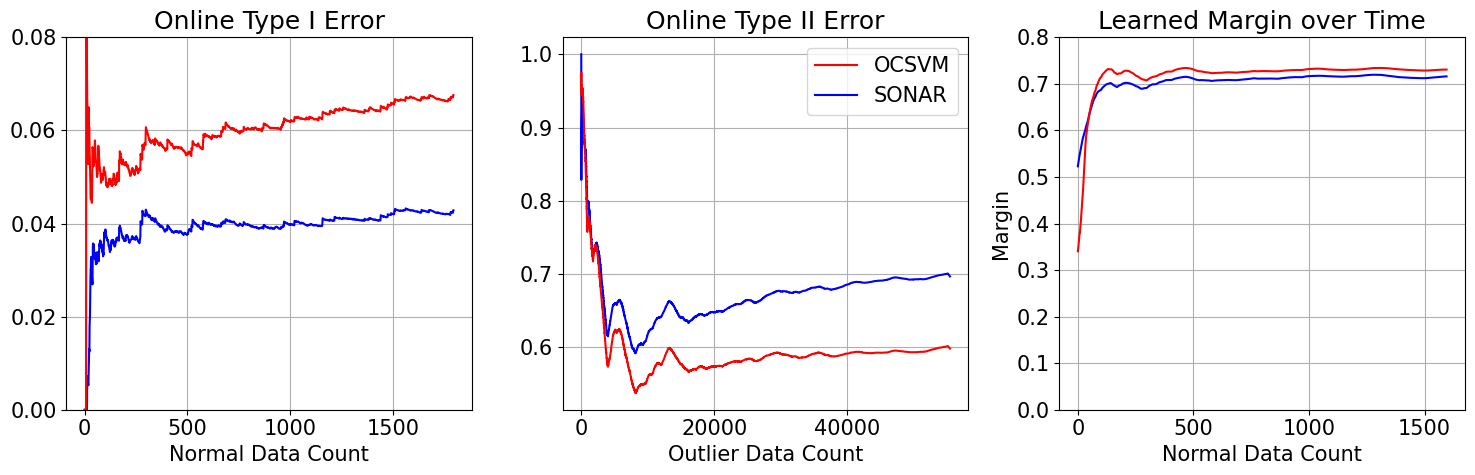

33_1


online type 1 error
OCSVM 0.06760445682451253
SONAR 0.04284122562674095
Normal data count 1795


online type 2 error
OCSVM 0.5982534876176058
SONAR 0.6967737284164234
Outlier data count 55482


last iterate type 1 error
OCSVM 0.1583286908077995
SONAR 0.07763231197771589
Normal data count 1795


last iterate type 2 error
OCSVM 0.7591092606611152
SONAR 0.8550926426588804
Outlier data count 55482


OCSVM Margin Statistics
Mean: 0.6853227036787851
Std dev: 0.21645412107305023
Min: -1.2236244160336907
Max: 0.8355998709905463
Median: 0.728176535020588
25th percentile: 0.7206810544391156
75th percentile: 0.7342096882830401
last: 0.7240721328772152


SONAR Margin Statistics
Mean: 0.69048615979502
Std dev: 0.08816594650879406
Min: -0.04843930057224134
Max: 0.7943149185722856
Median: 0.7122790513311577
last: 0.7095146123308143


In [20]:
# visualize results for just SONAR and OCSVM (Aposemat IoT-23 Dataset)

font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)

plt.clf()  # Clears the current figure

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# === LEFT: Cumulative 0-1 loss over time ===

ax1.plot(np.arange(len(avg_cum_errors)), avg_cum_errors / (1+np.arange(len(avg_cum_errors))), color='blue', label='SONAR')
ax1.plot(np.arange(len(avg_cum_errors_noreg)), avg_cum_errors_noreg / (1+np.arange(len(avg_cum_errors_noreg))), color='red', label='OCSVM')
ax1.set_xlabel(f"Normal Data Count")
# ax1.set_ylabel("Type I Error")
ax1.set_title("Online Type I Error")

# Map each dataset name to its preferred y-limits
ylims_1 = {
    "33_1": (0,0.08),
}

# Safely get ylim for the current dataset
ylim1 = ylims_1.get(data_name)

# Apply only if we have a match
if ylim1 is not None:
    ax1.set(ylim=ylim1)

ax1.autoscale(enable=None, axis="y", tight=False)
ax1.grid(True)
# Apply formatting to the SAME ax1 object
from matplotlib.ticker import StrMethodFormatter, MaxNLocator
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))  # 3 decimal places for small numbers

# === CENTER: outlier errors ===

times = np.arange(len(avg_out_cum_errors)) + 1
ax2.plot(times, avg_out_cum_errors / times, color='blue', label='SONAR')
ax2.plot(times, avg_out_cum_errors_noreg / times, color='red', label='OCSVM')


ax2.set_xlabel(f"Outlier Data Count")
ax2.set_title("Online Type II Error")
ax2.grid(True)
handles, labels = ax2.get_legend_handles_labels()
order = [1,0]

ax2.legend([handles[i] for i in order], 
           [labels[i] for i in order])

# === RIGHT: margin over time ===
window_size=200

avg_radii_s = moving_average(avg_radii, window_size=window_size)
avg_radii_noreg_s = moving_average(avg_radii_noreg,window_size=window_size)

ax3.plot(np.arange(len(avg_radii_s)), avg_radii_s, color='blue', label='SONAR')
ax3.plot(np.arange(len(avg_radii_noreg_s)), avg_radii_noreg_s, color='red', label='OCSVM')
ax3.set_xlabel(f"Normal Data Count")
ax3.set_ylabel("Margin")
ax3.set_title("Learned Margin over Time")
ax3.grid(True)
# ax3.legend()

ylims = {
    "33_1":   (0, 0.8),
}
ylim = ylims.get(data_name)

# Apply only if we have a match
if ylim is not None:
    ax3.set(ylim=ylim)

ax3.autoscale(enable=None, axis="y", tight=False)

plt.tight_layout()
plt.savefig(f"figs/{data_name}_lambda_{lambda_param}.png")
plt.show()

# Use it like this:
tee = TeeLogger(f"results/{data_name}_lambda_{lambda_param}.txt")
old_stdout = sys.stdout
sys.stdout = tee  # redirect

# === your prints go here ===
print(f"{data_name}")

print("\n\nonline type 1 error")
print(f"OCSVM {avg_cum_errors_noreg[-1] / normal_count}")
print(f"SONAR {avg_cum_errors[-1] / normal_count}")
print(f"Normal data count {normal_count}")

print("\n\nonline type 2 error")
print(f"OCSVM {avg_out_cum_errors_noreg[-1] / outlier_counts}")
print(f"SONAR {avg_out_cum_errors[-1] / outlier_counts}")
print(f"Outlier data count {outlier_counts}")

print("\n\nlast iterate type 1 error")
print(f"OCSVM {f1_n}")
print(f"SONAR {f1}")
print(f"Normal data count {normal_count}")

print("\n\nlast iterate type 2 error")
print(f"OCSVM {f2_n}")
print(f"SONAR {f2}")
print(f"Outlier data count {outlier_counts}")

vec = avg_radii_noreg
print("\n\nOCSVM Margin Statistics")
print("Mean:", np.mean(vec))
print("Std dev:", np.std(vec))
print("Min:", np.min(vec))
print("Max:", np.max(vec))
print("Median:", np.median(vec))
print("25th percentile:", np.percentile(vec, 25))
print("75th percentile:", np.percentile(vec, 75))
print("last:", vec[-1])
# print(vec[-5:])

vec = avg_radii
print("\n\nSONAR Margin Statistics")
print("Mean:", np.mean(vec))
print("Std dev:", np.std(vec))
print("Min:", np.min(vec))
print("Max:", np.max(vec))
print("Median:", np.median(vec))
print("last:", vec[-1])

# restore stdout
sys.stdout = old_stdout
tee.file.close()